# 1. Exploración inicial

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_drugs = pd.read_excel("./src/data/data_drugs.xlsx", header = 2)
df_drugs.head()

,Country,Country code,Survey year,Prevalence (%),Substance,Recall period,Age,Sample size,Males (%),Females (%)
0,Austria,AT,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650,24.8,20.6
1,Austria,AT,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712,26.8,27.6
2,Austria,AT,2020,6.3,Cannabis,Last year,Adults (15-64),4650,6.8,5.8
3,Austria,AT,2020,11.1,Cannabis,Last year,Young adults (15-34),1712,10.7,11.4
4,Austria,AT,2020,3.6,Cannabis,Last month,Adults (15-64),4650,4,3.1


In [3]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         1043 non-null   object 
 1   Country code    1043 non-null   object 
 2   Survey year     1043 non-null   int64  
 3   Prevalence (%)  1043 non-null   float64
 4   Substance       1043 non-null   object 
 5   Recall period   1043 non-null   object 
 6   Age             1043 non-null   object 
 7   Sample size     1043 non-null   object 
 8   Males (%)       1043 non-null   object 
 9   Females (%)     1043 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 81.6+ KB


In [4]:
df_drugs.nunique()

Country            29
Country code       29
Survey year        12
Prevalence (%)    358
Substance           7
Recall period       3
Age                 2
Sample size        77
Males (%)         378
Females (%)       334
dtype: int64

## 1.1. Observaciones
Country code lo podemos eliminar, ya que significa lo mismo que Country.

Survey year es entero, y tengo datos de 12 años distintos, buena progresión.

Prevalence es float.

Recall period indica el periodo de tiempo de consumo. Lifetime es alguna vez en la vida, last year en el último año y last month en el último mes.

Age indica dos ventanas de edad, de 15-34 y de 15-64, lo que no entiendo es porqué el segundo tramo no empieza en 35 directamente. Están los datos acumulados?

Sample size indica el total de personas encuestadas. Que deberíamos pasar a numérico.

Males y females son porcentajes de hombres y mujeres, que también pasaremos a numérico.

## 1.2. Definición de hipótesis iniciales

🔹 Hipótesis 1: Existen diferencias significativas en la prevalencia del consumo de determinadas drogas entre países europeos.


🔹 Hipótesis 2: La prevalencia del consumo varía de forma notable según el recall period, siendo mayor en medidas de consumo a lo largo de la vida que en periodos recientes.


🔹 Hipótesis 3: Las diferencias de consumo entre hombres y mujeres varían según la sustancia analizada.


🔹 Hipótesis 4: Algunas sustancias muestran patrones de consumo más homogéneos entre países que otras.


# 2. Limpieza de datos

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# comienzo unificando los nombres de las columnas para evitar problemas
df_drugs.columns = (df_drugs.columns.str.lower().str.replace(" ", "_"))

## 2.1. Tratamiento de faltantes

In [7]:
df_drugs.isna().sum()

country           0
country_code      0
survey_year       0
prevalence_(%)    0
substance         0
recall_period     0
age               0
sample_size       0
males_(%)         0
females_(%)       0
dtype: int64

En la revisión inicial de dataframe he visto huecos, pero isna no los detecta porque no son NA. Vamos a corregir los tipos de datos primero y volvemos a revisar.

## 2.2. Conversión de tipo de dato

In [8]:
df_drugs.dtypes

country            object
country_code       object
survey_year         int64
prevalence_(%)    float64
substance          object
recall_period      object
age                object
sample_size        object
males_(%)          object
females_(%)        object
dtype: object

In [9]:
cols_to_numeric = ["sample_size", "males_(%)", "females_(%)"]

for col in cols_to_numeric:
    df_drugs[col] = pd.to_numeric(df_drugs[col], errors="coerce")


In [10]:
df_drugs[cols_to_numeric].isna().sum()


sample_size    93
males_(%)      26
females_(%)    42
dtype: int64

Retomamos el tratamiento de faltantes por los nuevos NA que han aparecido con los cambios de tipo, que coinciden con los huecos vacíos.

Decisión:
No considero sensato imputar ninguna de las tres columnas, ni eliminar los datos ni imputarlo a la media, ya que no tiene sentido. No quiero perder las filas porque tengo datos válidos de ese país en prevalence, así que voy a manejar el dataframe con los faltantes y usaré un filtro sin NA cuando lo necesite.

In [11]:
df_sample = df_drugs.dropna(subset=["sample_size"])
df_sex = df_drugs.dropna(subset=["males_(%)", "females_(%)"])
df_sin_na = df_drugs.dropna()

## 2.3. Identificación y gestión de duplicados 

In [12]:
df_drugs.duplicated().sum()

np.int64(0)

No existen duplicados así que no se ha realizado ninguna acción. 

## 2.4. Detección y manejo de outliers

In [13]:
df_drugs.describe()

,survey_year,prevalence_(%),sample_size,males_(%),females_(%)
count,1043.000000,1043.000000,950.000000,1017.000000,1001.000000
mean,2018.776606,17.558581,4260.586316,19.904621,15.596803
std,2.174479,26.759251,4568.853108,28.697494,25.437743
min,2008.000000,0.000000,442.000000,0.000000,0.000000
25%,2018.000000,0.600000,1572.000000,0.800000,0.300000
50%,2019.000000,2.800000,2957.000000,3.900000,1.800000
75%,2020.000000,26.150000,4994.000000,32.000000,21.300000
max,2022.000000,98.900000,26344.000000,99.600000,98.200000


In [14]:
Q1 = df_drugs["prevalence_(%)"].quantile(0.25)
Q3 = df_drugs["prevalence_(%)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(np.float64(-37.724999999999994), np.float64(64.475))

In [15]:
outliers = df_drugs[
    (df_drugs["prevalence_(%)"] < lower_bound) |
    (df_drugs["prevalence_(%)"] > upper_bound)
]

outliers.shape

(114, 10)

In [16]:
outliers.head()

,country,country_code,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%)
30,Austria,AT,2020,94.9,Alcohol,Lifetime,Adults (15-64),4650.0,95.4,94.3
31,Austria,AT,2020,90.1,Alcohol,Lifetime,Young adults (15-34),1712.0,89.7,90.4
32,Austria,AT,2020,85.3,Alcohol,Last year,Adults (15-64),4650.0,86.2,84.4
33,Austria,AT,2020,76.8,Alcohol,Last year,Young adults (15-34),1712.0,76.4,77.2
34,Austria,AT,2020,77.2,Alcohol,Last month,Adults (15-64),4650.0,79.8,74.5


<Axes: >

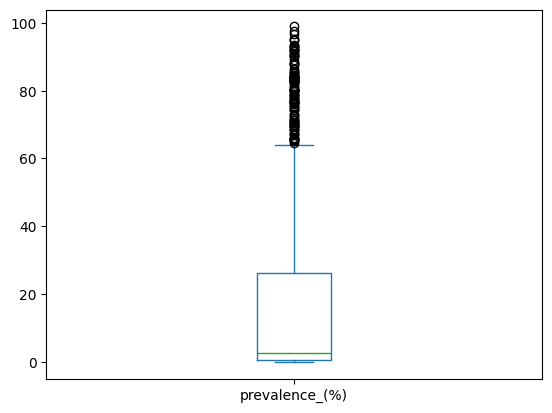

In [17]:
df_drugs["prevalence_(%)"].plot(kind="box")


Dado que los valores extremos detectados mediante el análisis descriptivo pueden reflejar diferencias reales entre países, sustancias(sobre todo por el alcohol que está más normalizado) o periodos de recuerdo, se ha optado por conservarlos en el conjunto de datos y analizarlos de forma contextualizada en etapas posteriores del proyecto.

## 2.5. Eliminación de columnas innecesarias

In [18]:
df_drugs = df_drugs.drop(columns=["country_code"])

## 2.6. Estandarización o normalización si aplica
En nuestro caso no aplica

## 2.7. Creación de nuevas variables
Voy a crear una nueva variable que indique la desigualdad entre sexos en una sola variable, así facilita las comparaciones entre países, años o sustancias


In [19]:
df_drugs["gender_gap"] = (df_drugs["males_(%)"] - df_drugs["females_(%)"])


## 2.8. Guardado de datos

In [20]:
df_drugs.to_csv("./src/data/data_clean/drugs.csv")
df_drugs_no_na = df_drugs.dropna()
df_drugs_no_na.to_csv("./src/data/data_clean/drugs_no_na.csv")

# 3. EDA ANÁLISIS UNIVARIANTE

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from IPython.display import display
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
import itertools
import os


In [22]:
from src.utils.funciones import (cardinalidad, pinta_distribucion_categoricas, columnas_numericas, plot_multiple_boxplots,
                            plot_histo_dens, plot_combined_graphs, plot_categorical_relationship_fin, 
                            grafico_dispersion_con_correlacion, guardar_figura)


In [23]:
df_drugs = pd.read_csv("./src/data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("./src/data/data_clean/drugs_no_na.csv", index_col=0)

## 3.1. Distribución del sexo

In [24]:
df_drugs[["males_(%)", "females_(%)"]].describe()

,males_(%),females_(%)
count,1017.000000,1001.000000
mean,19.904621,15.596803
std,28.697494,25.437743
min,0.000000,0.000000
25%,0.800000,0.300000
50%,3.900000,1.800000
75%,32.000000,21.300000
max,99.600000,98.200000


El análisis univariante del consumo de estupefacientes según el sexo evidencia una mayor prevalencia de consumo en hombres respecto a mujeres. En el conjunto del dataset, la prevalencia media de consumo en hombres alcanza el 19,9 %, mientras que en mujeres se sitúa en torno al 15,6 %.
Esta diferencia se mantiene al analizar la mediana de la distribución, con valores del 3,9 % en hombres y del 1,8 % en mujeres, lo que sugiere que la brecha de género no se limita a valores extremos, sino que está presente en el conjunto de la distribución. Asimismo, la amplitud de los valores observados indica una elevada variabilidad en los niveles de consumo.

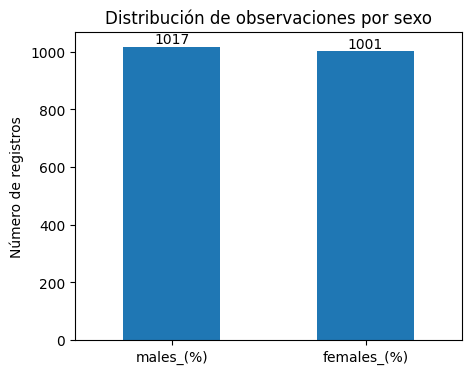

In [55]:
plt.figure(figsize=(5, 4))

frecuencia_sexo = df_drugs[["males_(%)", "females_(%)"]].notna().sum()
ax = frecuencia_sexo.plot(kind="bar")

plt.title("Distribución de observaciones por sexo")
plt.ylabel("Número de registros")
plt.xticks(rotation=0)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom"
    )

plt.savefig(
    "src/img/analisis_univariante/01_frecuencia_por_sexo.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## 3.2. Distribución de la edad

In [28]:
df_drugs["age"].describe()

count               1043
unique                 2
top       Adults (15-64)
freq                 528
Name: age, dtype: object

El análisis de la variable edad muestra que el conjunto de datos distingue únicamente entre dos grupos de edad, siendo el grupo Adults (15–64) el más representado en el dataset, con 528 registros, frente al resto de grupos de edad. Esta distribución refleja una mayor disponibilidad de información para la población adulta, lo que debe tenerse en cuenta a la hora de interpretar los resultados relacionados con el consumo.

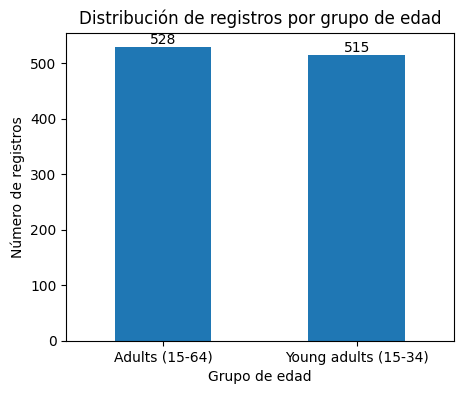

In [56]:
plt.figure(figsize=(5, 4))

frecuencia_edad = df_drugs["age"].value_counts()
ax = frecuencia_edad.plot(kind="bar")

plt.title("Distribución de registros por grupo de edad")
plt.ylabel("Número de registros")
plt.xlabel("Grupo de edad")
plt.xticks(rotation=0)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom"
    )

plt.savefig(
    "src/img/analisis_univariante/02_frecuencia_por_edad.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



El análisis univariante por grupo de edad muestra que el conjunto de datos distingue únicamente entre dos categorías etarias, siendo la población adulta (15–64 años) la más representada. Al comparar la prevalencia media de consumo entre los grupos de edad, se observan diferencias que sugieren patrones de consumo diferenciados. Sin embargo, la limitada desagregación de la variable edad constituye una restricción del análisis, ya que impide evaluar el consumo en rangos etarios más específicos.

## 3.3. Distribución de los países

In [29]:
df_drugs["country"].describe()

count        1043
unique         29
top       Austria
freq           42
Name: country, dtype: object

El análisis de la variable país muestra que el conjunto de datos incluye información de 29 países europeos, con una distribución desigual del número de registros por país. Austria es el país con mayor representación en el dataset, con 42 observaciones, mientras que otros países presentan una menor frecuencia de registros. Esta heterogeneidad en la representación debe tenerse en cuenta al analizar y comparar los niveles de consumo entre países.

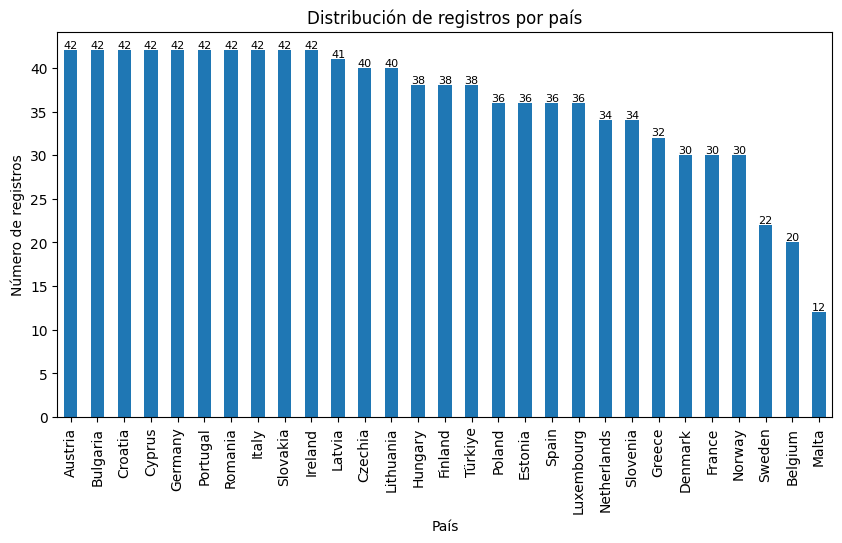

In [ ]:
plt.figure(figsize=(10, 5))

frecuencia_pais = df_drugs["country"].value_counts()
ax = frecuencia_pais.plot(kind="bar")

plt.title("Distribución de registros por país")
plt.ylabel("Número de registros")
plt.xlabel("País")
plt.xticks(rotation=90)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.savefig(
    "src/img/analisis_univariante/03_frecuencia_por_pais.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## 3.2. Distribución del tipo de sustancia

In [30]:
df_drugs["substance"].describe()

count         1043
unique           7
top       Cannabis
freq           171
Name: substance, dtype: object

El análisis univariante por tipo de sustancia muestra que el cannabis es la sustancia con mayor número de registros en el conjunto de datos, seguido de cocaína y éxtasis, lo que indica una representación relativamente equilibrada entre varias sustancias ilegales.

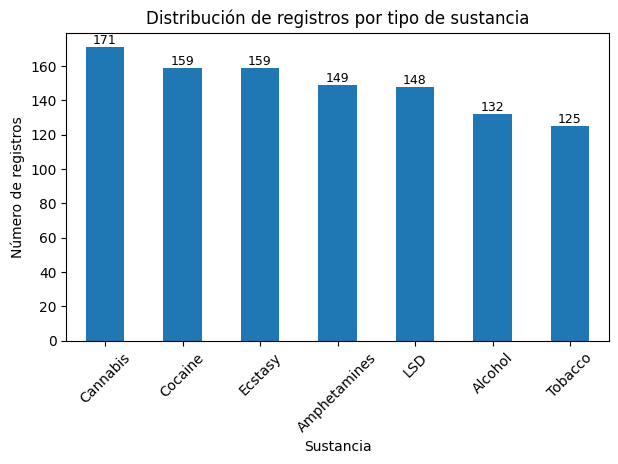

In [58]:
plt.figure(figsize=(7, 4))

frecuencia_sustancia = df_drugs["substance"].value_counts()
ax = frecuencia_sustancia.plot(kind="bar")

plt.title("Distribución de registros por tipo de sustancia")
plt.ylabel("Número de registros")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.savefig(
    "src/img/analisis_univariante/04_frecuencia_por_sustancia.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


### Conclusión análisis univariante
De forma preliminar, los resultados del análisis univariante sugieren la existencia de diferencias en los patrones de consumo tanto según el sexo como según el país. No obstante, estas observaciones descriptivas deben interpretarse con cautela, ya que no consideran de manera conjunta las posibles interacciones entre variables. Por este motivo, se procede a continuación a un análisis bivariante que permita evaluar las hipótesis planteadas de forma más precisa.

# 4. EDA ANÁLISIS BIVARIANTE

## 4.1. Consumo según sexo

In [41]:
df_drugs[["males_(%)", "females_(%)"]].agg(["count", "mean", "median", "std"])


,males_(%),females_(%)
count,1017.000000,1001.000000
mean,19.904621,15.596803
median,3.900000,1.800000
std,28.697494,25.437743


/var/folders/24/l_63d9xn1mzflxp35w396r580000gn/T/ipykernel_35700/4239700689.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


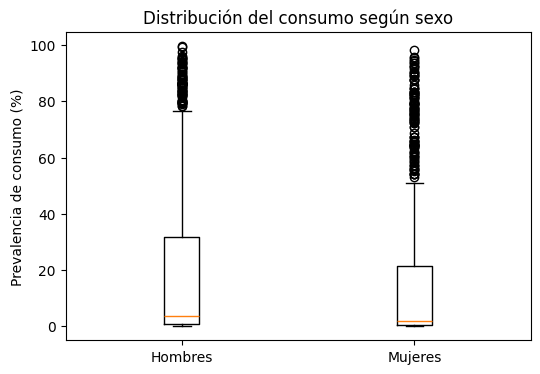

In [48]:
plt.figure(figsize=(6, 4))
plt.boxplot(
    [df_drugs_no_na["males_(%)"], df_drugs_no_na["females_(%)"]],
    labels=["Hombres", "Mujeres"],
    showfliers=True
)
plt.title("Distribución del consumo según sexo")
plt.ylabel("Prevalencia de consumo (%)")

plt.savefig(
    "src/img/analisis_bivariante/01_boxplot_consumo_sexo.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


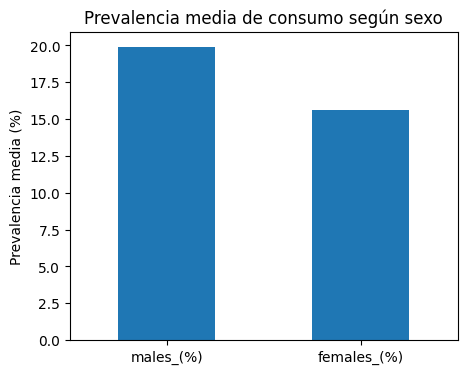

In [49]:
medias_sexo = df_drugs[["males_(%)", "females_(%)"]].mean()

plt.figure(figsize=(5, 4))
medias_sexo.plot(kind="bar")
plt.title("Prevalencia media de consumo según sexo")
plt.ylabel("Prevalencia media (%)")
plt.xticks(rotation=0)

plt.savefig(
    "src/img/analisis_bivariante/media_consumo_sexo.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


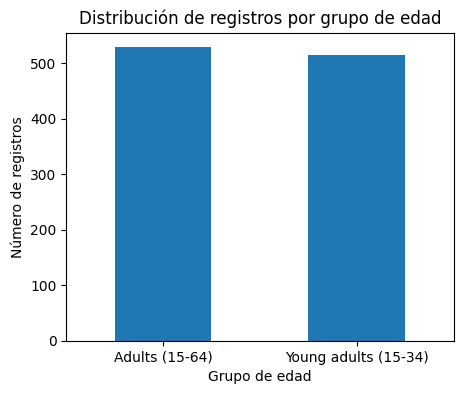

In [51]:
plt.figure(figsize=(5, 4))
df_drugs["age"].value_counts().plot(kind="bar")
plt.title("Distribución de registros por grupo de edad")
plt.ylabel("Número de registros")
plt.xlabel("Grupo de edad")
plt.xticks(rotation=0)

plt.savefig(
    "src/img/analisis_univariante/frecuencia_por_edad.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


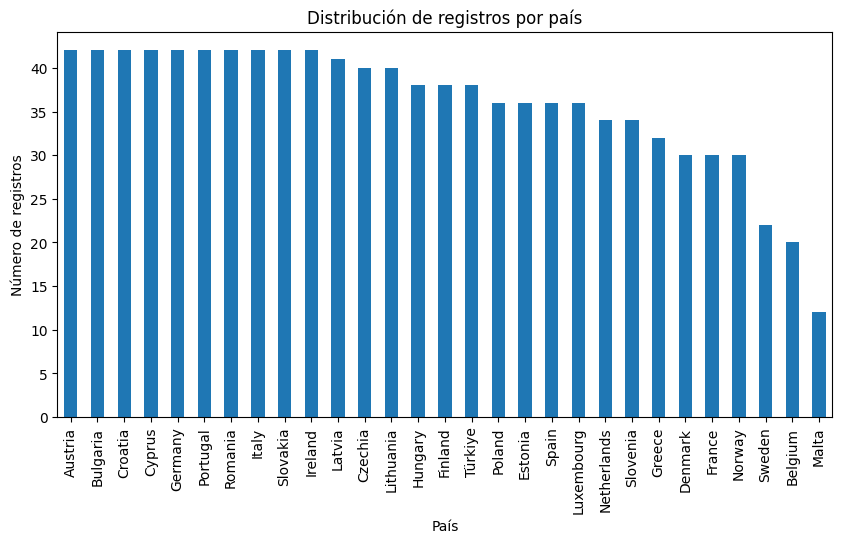

In [52]:
plt.figure(figsize=(10, 5))
df_drugs["country"].value_counts().plot(kind="bar")
plt.title("Distribución de registros por país")
plt.ylabel("Número de registros")
plt.xlabel("País")
plt.xticks(rotation=90)

plt.savefig(
    "src/img/analisis_univariante/frecuencia_por_pais.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


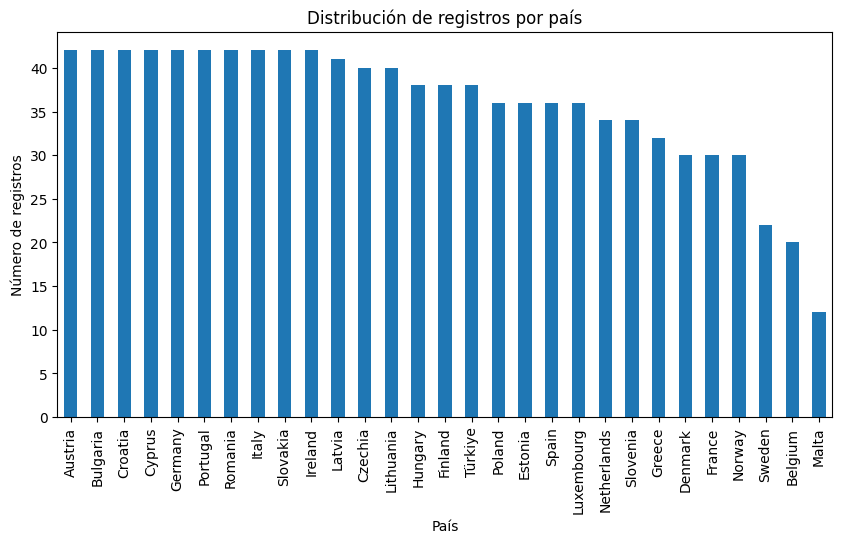

In [53]:
plt.figure(figsize=(10, 5))
df_drugs["country"].value_counts().plot(kind="bar")
plt.title("Distribución de registros por país")
plt.ylabel("Número de registros")
plt.xlabel("País")
plt.xticks(rotation=90)

plt.savefig(
    "src/img/analisis_univariante/frecuencia_por_pais.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
